# Classification Methods: Predicting Hotel Cancellations

### Python version

In [1]:
from platform import python_version
print(python_version())

### Import Libraries

In [2]:
import csv
import imblearn
import matplotlib.pyplot as plt
import mglearn
import numpy as np
from numpy.random import seed
seed(1)

import os
import pandas as pd
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

### Import Data From AWS S3 to Sagemaker

In [3]:
# import boto3
# import botocore
# from sagemaker import get_execution_role

# role = get_execution_role()

# bucket = 'enterbucketname'
# data_key_train = 'H1.csv'
# data_location_train = 's3://{}/{}'.format(bucket, data_key_train)

# train_df = pd.read_csv(data_location_train)

### Import Data From Azure Blob Storage to Azure Machine Learning Studio

In [4]:
# from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient

# #download csv file from Azure blob

# sas_url = "enter url here"
# blob_client = BlobClient.from_blob_url(sas_url)
# downloaded_blo = blob_client.download_blob()

In [5]:
# from io import StringIO
# blob_data = blob_client.download_blob()
# train_df = pd.read_csv(StringIO(blob_data.content_as_text()))
# print(train_df)

### Import Data Through CSV

In [6]:
train_df = pd.read_csv('H1.csv')
a=train_df.head()
b=train_df
b
b.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0,212,2017,August,35,31,2,8,2,1,...,No Deposit,143,NULL,0,Transient,89.75,0,0,Check-Out,2017-09-10
40056,0,169,2017,August,35,30,2,9,2,0,...,No Deposit,250,NULL,0,Transient-Party,202.27,0,1,Check-Out,2017-09-10
40057,0,204,2017,August,35,29,4,10,2,0,...,No Deposit,250,NULL,0,Transient,153.57,0,3,Check-Out,2017-09-12
40058,0,211,2017,August,35,31,4,10,2,0,...,No Deposit,40,NULL,0,Contract,112.80,0,1,Check-Out,2017-09-14


In [7]:
IsCanceled = train_df['IsCanceled']
y = IsCanceled

### Numerical Variables

In [8]:
leadtime = train_df['LeadTime']
arrivaldateweekno = train_df['ArrivalDateWeekNumber']
arrivaldatedayofmonth = train_df['ArrivalDateDayOfMonth']
staysweekendnights = train_df['StaysInWeekendNights']
staysweeknights = train_df['StaysInWeekNights']
adults = train_df['Adults']
children = train_df['Children']
babies = train_df['Babies']
previouscancellations = train_df['PreviousCancellations']
previousbookingsnotcanceled = train_df['PreviousBookingsNotCanceled']
bookingchanges = train_df['BookingChanges']
dayswaitinglist = train_df['DaysInWaitingList']
adr = train_df['ADR']
rcps = train_df['RequiredCarParkingSpaces']
totalsqr = train_df['TotalOfSpecialRequests']

### Categorical Variables

In [9]:
arrivaldatemonth = train_df.ArrivalDateMonth.astype("category").cat.codes
arrivaldatemonthcat=pd.Series(arrivaldatemonth)
mealcat=train_df.Meal.astype("category").cat.codes
mealcat=pd.Series(mealcat)
countrycat=train_df.Country.astype("category").cat.codes
countrycat=pd.Series(countrycat)
marketsegmentcat=train_df.MarketSegment.astype("category").cat.codes
marketsegmentcat=pd.Series(marketsegmentcat)
distributionchannelcat=train_df.DistributionChannel.astype("category").cat.codes
distributionchannelcat=pd.Series(distributionchannelcat)
reservedroomtypecat=train_df.ReservedRoomType.astype("category").cat.codes
reservedroomtypecat=pd.Series(reservedroomtypecat)
assignedroomtypecat=train_df.AssignedRoomType.astype("category").cat.codes
assignedroomtypecat=pd.Series(assignedroomtypecat)
deposittypecat=train_df.DepositType.astype("category").cat.codes
deposittypecat=pd.Series(deposittypecat)
customertypecat=train_df.CustomerType.astype("category").cat.codes
customertypecat=pd.Series(customertypecat)
reservationstatuscat=train_df.ReservationStatus.astype("category").cat.codes
reservationstatuscat=pd.Series(reservationstatuscat)
isrepeatedguestcat = train_df.IsRepeatedGuest.astype("category").cat.codes
isrepeatedguestcat=pd.Series(isrepeatedguestcat)
agentcat = train_df.Agent.astype("category").cat.codes
agentcat=pd.Series(agentcat)
companycat = train_df.Company.astype("category").cat.codes
companycat=pd.Series(companycat)

In [10]:
x = np.column_stack((leadtime,arrivaldatemonthcat,arrivaldateweekno,arrivaldatedayofmonth,staysweekendnights,staysweeknights,adults,children,babies,mealcat,countrycat,marketsegmentcat,distributionchannelcat,isrepeatedguestcat,previouscancellations,previousbookingsnotcanceled,reservedroomtypecat,assignedroomtypecat,bookingchanges,deposittypecat,dayswaitinglist,customertypecat,adr,rcps,totalsqr,reservationstatuscat))
x = sm.add_constant(x, prepend=True)

In [11]:
x1_train, x1_val, y1_train, y1_val = train_test_split(x, y, random_state=0)

In [12]:
x1_train.shape

(30045, 27)

In [13]:
x1_val.shape

(10015, 27)

In [14]:
y1_train.shape

(30045,)

In [15]:
y1_val.shape

(10015,)

### PCA

In [16]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x1_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d=np.argmax(cumsum >= 0.95) + 1

In [17]:
cumsum

array([0.65268802, 0.91585162, 0.97544116, 0.98866666, 0.99408994,
       0.9977992 , 0.99848658, 0.99894959, 0.99933368, 0.99947797,
       0.99959497, 0.99966931, 0.99973189, 0.99978591, 0.99982632,
       0.99986507, 0.99990079, 0.99993411, 0.99995573, 0.99996792,
       0.99997887, 0.99998639, 0.99999363, 0.99999677, 0.99999906,
       1.        , 1.        ])

In [18]:
d

3

In [19]:
model = PCA(n_components=3).fit(x1_train)
X_pc = model.transform(x1_train)

# number of components
n_pcs= model.components_.shape[0]

In [20]:
n_pcs

3

In [21]:
pca.explained_variance_ratio_

array([6.52688022e-01, 2.63163603e-01, 5.95895365e-02, 1.32254985e-02,
       5.42328291e-03, 3.70926122e-03, 6.87380784e-04, 4.63008004e-04,
       3.84090776e-04, 1.44281661e-04, 1.17006860e-04, 7.43367867e-05,
       6.25794130e-05, 5.40171237e-05, 4.04148996e-05, 3.87491097e-05,
       3.57161629e-05, 3.33265022e-05, 2.16184565e-05, 1.21909359e-05,
       1.09492387e-05, 7.52357163e-06, 7.23871150e-06, 3.13788560e-06,
       2.28437419e-06, 9.44680088e-07, 4.56321723e-33])

In [22]:
pca.components_

array([[ 1.29391511e-19,  9.98450351e-01,  5.03553775e-03,
         1.84755540e-02, -2.27091827e-03,  3.89020715e-03,
         9.84851725e-03,  1.08324413e-03,  5.48629159e-05,
        -3.16758945e-07,  1.64897189e-03, -3.10833223e-02,
         1.58160168e-03,  1.17682276e-03, -3.31724266e-04,
         1.24164543e-03, -1.19571753e-03,  1.76223607e-04,
        -2.02214195e-03,  6.17543877e-04,  4.53981462e-04,
         6.46044881e-03,  4.87158248e-05,  3.98486058e-02,
        -5.23947495e-04,  1.48740555e-05, -1.11352763e-03],
       [ 1.85461529e-18, -4.04594046e-02, -1.63647175e-02,
         3.58197484e-02,  5.99604805e-03,  1.52521301e-03,
         3.84870448e-03,  2.17873493e-03,  2.60436245e-03,
         1.05660885e-04,  2.40852883e-03, -7.18970135e-04,
         4.19967877e-03,  1.29768657e-03, -3.29390629e-04,
        -1.05860329e-03, -1.34144831e-03,  1.32343491e-02,
         8.47816227e-03,  2.73136399e-04, -4.19323227e-04,
        -2.16835399e-03, -6.20292304e-04,  9.98228102e-

In [23]:
# https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components

most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
most_important

[1, 23, 11]

In [24]:
initial_feature_names = ['leadtime','arrivaldatemonthcat','arrivaldateweekno','arrivaldatedayofmonth','staysweekendnights','staysweeknights','adults','children','babies','mealcat','countrycat','marketsegmentcat','distributionchannelcat','isrepeatedguestcat','previouscancellations','previousbookingsnotcanceled','reservedroomtypecat','assignedroomtypecat','bookingchanges','deposittypecat','dayswaitinglist','customertypecat','adr','rcps','totalsqr','reservationstatuscat']
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
df = pd.DataFrame(dic.items())

In [25]:
df

,0,1
0,PC0,arrivaldatemonthcat
1,PC1,rcps
2,PC2,marketsegmentcat


In [26]:
x = np.column_stack((arrivaldatemonthcat,marketsegmentcat,rcps))
x = sm.add_constant(x, prepend=True)

In [27]:
x1_train, x1_val, y1_train, y1_val = train_test_split(x, y, random_state=0)

In [28]:
x1_train.shape

(30045, 4)

In [29]:
x1_val.shape

(10015, 4)

In [30]:
y1_train.shape

(30045,)

In [31]:
y1_val.shape

(10015,)

### SVM

In [32]:
# https://stackoverflow.com/questions/52896387/svc-with-class-weight-in-scikit-learn
from sklearn import svm
clf = svm.SVC(gamma='scale', 
            class_weight='balanced')
clf.fit(x1_train, y1_train)  
prclf = clf.predict(x1_val)
prclf

array([0, 0, 1, ..., 0, 0, 1])

In [33]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y1_val,prclf))
print(classification_report(y1_val,prclf))

[[3950 3316]
 [ 755 1994]]
              precision    recall  f1-score   support

           0       0.84      0.54      0.66      7266
           1       0.38      0.73      0.49      2749

    accuracy                           0.59     10015
   macro avg       0.61      0.63      0.58     10015
weighted avg       0.71      0.59      0.61     10015



### XGBOOST

In [34]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(learning_rate=0.001,
                            max_depth = 1, 
                            n_estimators = 100,
                              scale_pos_weight=3)
xgb_model.fit(x1_train, y1_train)

print("Accuracy on training set: {:.3f}".format(xgb_model.score(x1_train, y1_train)))
print("Accuracy on validation set: {:.3f}".format(xgb_model.score(x1_val, y1_val)))

Accuracy on training set: 0.415
Accuracy on validation set: 0.414


In [35]:
xgb_predict=xgb_model.predict(x1_val)
xgb_predict

array([1, 1, 1, ..., 1, 1, 1])

In [36]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y1_val,xgb_predict))
print(classification_report(y1_val,xgb_predict))

[[1393 5873]
 [   0 2749]]
              precision    recall  f1-score   support

           0       1.00      0.19      0.32      7266
           1       0.32      1.00      0.48      2749

    accuracy                           0.41     10015
   macro avg       0.66      0.60      0.40     10015
weighted avg       0.81      0.41      0.37     10015



### Oversampling for Naive Bayes and KNN Models

In [37]:
counter = Counter(y1_train)
print(counter)

Counter({0: 21672, 1: 8373})


In [38]:
oversample = SMOTE()
x1_train, y1_train = oversample.fit_resample(x1_train, y1_train)

In [39]:
counter = Counter(y1_train)
print(counter)

Counter({1: 21672, 0: 21672})


### Naive Bayes

In [40]:
gnb = GaussianNB()
gnb

GaussianNB(priors=None, var_smoothing=1e-09)

In [41]:
y_pred = gnb.fit(x1_train, y1_train).predict(x1_val)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [42]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y1_val,y_pred))
print(classification_report(y1_val,y_pred))

[[1393 5873]
 [   0 2749]]
              precision    recall  f1-score   support

           0       1.00      0.19      0.32      7266
           1       0.32      1.00      0.48      2749

    accuracy                           0.41     10015
   macro avg       0.66      0.60      0.40     10015
weighted avg       0.81      0.41      0.37     10015



### KNN and SMOTE Oversampling

In [43]:
x1_train = MinMaxScaler().fit_transform(x1_train)

In [44]:
x1_train

array([[0.        , 0.09090909, 1.        , 0.        ],
       [0.        , 1.        , 1.        , 0.        ],
       [0.        , 1.        , 0.6       , 0.        ],
       ...,
       [0.        , 0.09090909, 1.        , 0.        ],
       [0.        , 0.54545455, 1.        , 0.        ],
       [0.        , 0.09090909, 1.        , 0.        ]])

Training set score: 0.66
Validation set score: 0.42


/home/michael/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


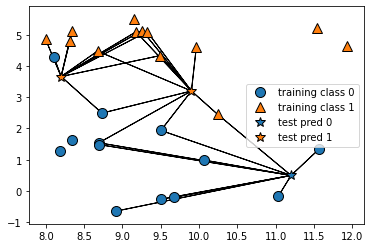

In [45]:
knn = KNeighborsClassifier(n_neighbors=10)
knn=knn.fit(x1_train, y1_train)
pred = knn.predict(x1_val)
pred
print("Training set score: {:.2f}".format(knn.score(x1_train, y1_train)))
print("Validation set score: {:.2f}".format(knn.score(x1_val, y1_val)))

# KNN Plot
mglearn.plots.plot_knn_classification(n_neighbors=10)
plt.show()

In [46]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y1_val,pred))
print(classification_report(y1_val,pred))

[[1429 5837]
 [   8 2741]]
              precision    recall  f1-score   support

           0       0.99      0.20      0.33      7266
           1       0.32      1.00      0.48      2749

    accuracy                           0.42     10015
   macro avg       0.66      0.60      0.41     10015
weighted avg       0.81      0.42      0.37     10015



## Test Data using SVM Model

### Import Data from AWS S3 to SageMaker

In [47]:
# data_key_test = 'H2.csv'
# data_location_test = 's3://{}/{}'.format(bucket, data_key_test)

# h2data = pd.read_csv(data_location_test)

### Import Data From Azure Blob Storage to Azure Machine Learning Studio

In [48]:
# sas_url = "enter url here"
# blob_client = BlobClient.from_blob_url(sas_url)
# downloaded_blo = blob_client.download_blob()

# from io import StringIO
# blob_data = blob_client.download_blob()
# h2data = pd.read_csv(StringIO(blob_data.content_as_text()))
# print(h2data)

### Import CSV

In [49]:
h2data = pd.read_csv('H2.csv')
a=h2data.head()
a

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


In [50]:
type(h2data)

pandas.core.frame.DataFrame

In [51]:
t_leadtime = h2data['LeadTime'] #1
t_arrivaldateyear = h2data['ArrivalDateYear']
t_arrivaldateweekno = h2data['ArrivalDateWeekNumber']
t_arrivaldatedayofmonth = h2data['ArrivalDateDayOfMonth']
t_staysweekendnights = h2data['StaysInWeekendNights'] #2
t_staysweeknights = h2data['StaysInWeekNights'] #3
t_adults = h2data['Adults'] #4
t_children = h2data['Children'] #5
t_babies = h2data['Babies'] #6
t_previouscancellations = h2data['PreviousCancellations'] #12
t_previousbookingsnotcanceled = h2data['PreviousBookingsNotCanceled'] #13
t_bookingchanges = h2data['BookingChanges'] #16
t_dayswaitinglist = h2data['DaysInWaitingList'] #20
t_adr = h2data['ADR'] #22
t_rcps = h2data['RequiredCarParkingSpaces'] #23
t_totalsqr = h2data['TotalOfSpecialRequests'] #24

In [52]:
t_arrivaldatemonth = h2data.ArrivalDateMonth.astype("category").cat.codes
t_arrivaldatemonthcat = pd.Series(t_arrivaldatemonth)
t_mealcat=h2data.Meal.astype("category").cat.codes
t_mealcat=pd.Series(t_mealcat)
t_countrycat=h2data.Country.astype("category").cat.codes
t_countrycat=pd.Series(t_countrycat)
t_marketsegmentcat=h2data.MarketSegment.astype("category").cat.codes
t_marketsegmentcat=pd.Series(t_marketsegmentcat)
t_distributionchannelcat=h2data.DistributionChannel.astype("category").cat.codes
t_distributionchannelcat=pd.Series(t_distributionchannelcat)
t_reservedroomtypecat=h2data.ReservedRoomType.astype("category").cat.codes
t_reservedroomtypecat=pd.Series(t_reservedroomtypecat)
t_assignedroomtypecat=h2data.AssignedRoomType.astype("category").cat.codes
t_assignedroomtypecat=pd.Series(t_assignedroomtypecat)
t_deposittypecat=h2data.DepositType.astype("category").cat.codes
t_deposittypecat=pd.Series(t_deposittypecat)
t_customertypecat=h2data.CustomerType.astype("category").cat.codes
t_customertypecat=pd.Series(t_customertypecat)
t_reservationstatuscat=h2data.ReservationStatus.astype("category").cat.codes
t_reservationstatuscat=pd.Series(t_reservationstatuscat)
t_isrepeatedguestcat = h2data.IsRepeatedGuest.astype("category").cat.codes
t_isrepeatedguestcat=pd.Series(t_isrepeatedguestcat)
t_agentcat = h2data.Agent.astype("category").cat.codes
t_agentcat=pd.Series(t_agentcat)
t_companycat = h2data.Company.astype("category").cat.codes
t_companycat=pd.Series(t_companycat)

In [53]:
a = np.column_stack((t_arrivaldatemonthcat,t_marketsegmentcat,t_rcps))
a = sm.add_constant(a, prepend=True)
IsCanceled = h2data['IsCanceled']
b = IsCanceled
b=b.values

In [54]:
prh2 = clf.predict(a)
prh2

array([1, 1, 1, ..., 1, 1, 1])

In [55]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(b,prh2))
print(classification_report(b,prh2))

[[ 9028 37200]
 [ 6274 26828]]
              precision    recall  f1-score   support

           0       0.59      0.20      0.29     46228
           1       0.42      0.81      0.55     33102

    accuracy                           0.45     79330
   macro avg       0.50      0.50      0.42     79330
weighted avg       0.52      0.45      0.40     79330

